# K-Means Scalability Benchmark: SizeUp Test

This notebook performs a comprehensive scalability analysis of different K-Means implementations, comparing their performance as data size increases. We test multiple approaches from single-node NumPy to distributed Spark implementations.

## Workflow
1. **Setup**: Import libraries and initialize Spark session
2. **Data Loading**: Load embeddings dataset and prepare features
3. **Model Configuration**: Define K-Means parameters and implementations to test
4. **Benchmark Execution**: Run SizeUp test with varying data sizes
5. **Results Analysis**: Visualize scalability characteristics

## 1. Setup and Imports

Import required libraries for distributed computing (PySpark), scientific computing (NumPy, Pandas), visualization (Matplotlib), and our custom K-Means implementations.

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

# Add current directory to path to ensure we can import our library
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

# Import our custom K-means library
from kmeans_scalability.models import (
    SparkMLKMeansModel,
    LocalNumPyKMeans,
    CustomRDDKMeansModel,
    CustomDataFrameKMeansModel,
    OptimizedDataFrameKMeansModel
)

# Configure Python executable for Spark to avoid environment mismatches
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

print(f"Python: {sys.version}")
print("Custom library imported successfully")

Python: 3.11.14 (main, Dec  9 2025, 18:59:10) [MSC v.1944 64 bit (AMD64)]
Custom library imported successfully


## 2. Initialize Spark Session

Configure a local Spark session with 16GB memory allocation for both driver and executor, optimized for processing large-scale embedding data.

In [2]:
# Create a dedicated temporary directory for Spark
spark_temp_dir = os.path.join(os.getcwd(), "spark_temp")
os.makedirs(spark_temp_dir, exist_ok=True)

# Initialize Spark Session with sufficient memory 
spark = SparkSession.builder \
    .appName("KMeans-SizeUp-Benchmark") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.local.dir", spark_temp_dir) \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Master: {spark.sparkContext.master}")
print(f"Default Parallelism: {spark.sparkContext.defaultParallelism}")

Spark Version: 3.5.7
Master: local[*]
Default Parallelism: 24


## 3. Load Embeddings Dataset

Load the GeoTessera embeddings from Parquet format and prepare feature vectors. The dataset contains 128-dimensional embeddings representing satellite imagery.

In [3]:
# Load the parquet data generated in the previous notebook
# We assume 'embeddings_temp.parquet' exists from the main notebook run
parquet_path = "GeoTessera_Pamplona_embeddings.parquet"

if not os.path.exists(parquet_path):
    print(f"Error: {parquet_path} not found. Please run the data generation steps in spark_kmeans_scalability.ipynb first.")
else:
    print(f"Loading data from {parquet_path}...")
    df_raw = spark.read.parquet(parquet_path)
    
    # Identify feature columns (0 to 127)
    skipcolumns = ['id', 'index' , 'lon', 'lat']
    sample_row = df_raw.first()
    feature_cols = [col for col in df_raw.columns if col not in skipcolumns]
 

    
    # Vector Assembler
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df = assembler.transform(df_raw).select("features")
    
    # Cache for performance during repeated sampling
    df.cache()
    print(f"Total rows: {df.count():,}")
    print("Data loaded and cached.")

Loading data from GeoTessera_Pamplona_embeddings.parquet...
Total rows: 1,879,040
Data loaded and cached.


## 4. Define Models and Parameters

Configure K-Means parameters ($k=4$, max iterations=10) and define the implementations to benchmark:
- **Local NumPy**: Single-node baseline implementation
- **Spark MLlib**: Official distributed K-Means
- **Custom RDD**: Custom implementation using Spark RDDs
- **Custom DataFrame (UDF)**: Custom implementation with User Defined Functions
- **Custom DataFrame (Optimized)**: Performance-optimized DataFrame implementation

In [4]:
# Define common parameters
k = 4
max_iter = 10
seed = 42

# Define the models to benchmark
models_to_test = {
    "Local NumPy (Baseline)": LocalNumPyKMeans(k=k, max_iter=max_iter, seed=seed),
    "Spark MLlib": SparkMLKMeansModel(k=k, max_iter=max_iter, seed=seed),
    "Custom RDD": CustomRDDKMeansModel(k=k, max_iter=max_iter, seed=seed),
    "Custom DataFrame (UDF)": CustomDataFrameKMeansModel(k=k, max_iter=max_iter, seed=seed),
    # Uncomment if you want to test the optimized version too
   "Custom DataFrame (Optimized)": OptimizedDataFrameKMeansModel(k=k, max_iter=max_iter, seed=seed)
}

print("Benchmarking the following models:")
for name in models_to_test:
    print(f" - {name}")

Benchmarking the following models:
 - Local NumPy (Baseline)
 - Spark MLlib
 - Custom RDD
 - Custom DataFrame (UDF)
 - Custom DataFrame (Optimized)


## 5. Run SizeUp Scalability Benchmark

Execute the benchmark across different data sizes (10%, 25%, 50%, 75%, 100%) to measure how each implementation scales. For each fraction, we train all models and record execution time and Within-Set Sum of Squared Errors (WSSSE).

In [5]:
# Define sampling fractions for SizeUp test
test_fractions = [0.1, 0.25, 0.5, 0.75, 1.0] 
# Note: For very large datasets, start smaller [0.01, 0.05, 0.1] to avoid waiting too long

results = []

print("Starting SizeUp Scalability Benchmark...")
print("="*80)

for fraction in test_fractions:
    # 1. Sample the data
    print(f"\nSampling fraction: {fraction:.2%}")
    sample_df = df.sample(withReplacement=False, fraction=fraction, seed=seed)
    # Collect numpy version for Local model ONCE per fraction
    # WARNING: Only do this if data fits in driver memory. For huge data, skip LocalNumPy.
    rows_count = sample_df.count()
    print(f"  Rows: {rows_count:,}")
    
    # Pre-collect data for local model to be fair (don't count collection time as training)
    try:
        if rows_count < 20000000000000: # Safety limit for local array
            local_data = sample_df.collect() 
        else:
            print("  Skipping Local NumPy for this size (limit exceeded)")
            local_data = None
    except Exception as e:
        print(f"  Could not collect local data: {e}")
        local_data = None

    for model_name, model_instance in models_to_test.items():
        print(f"  -> Running {model_name}...", end=" ", flush=True)
        
        try:
            # Handle input type differences
            if "Local" in model_name:
                if local_data is None:
                    print("SKIPPED (Data too large)")
                    continue
                input_data = local_data
            else:
                input_data = sample_df
            
            # Train and Measure
            model_instance.fit(input_data)
            
            # Record result
            results.append({
                "Fraction": fraction,
                "Samples": rows_count,
                "Model": model_name,
                "Time": model_instance.training_time,
                "WSSSE": getattr(model_instance, 'training_cost', 0) or 0
            })
            print(f"Done ({model_instance.training_time:.2f}s)")
            
        except Exception as e:
            print(f"FAILED: {e}")

print("\n" + "="*80)
print("Benchmark Complete.")

Starting SizeUp Scalability Benchmark...

Sampling fraction: 10.00%
  Rows: 188,908
  -> Running Local NumPy (Baseline)... Training Local NumPy K-means with k=4...
Training completed in 3.65 seconds
WSSSE: 54254459.07
Done (3.65s)
  -> Running Spark MLlib... Training Spark ML K-means with k=4...
Training completed in 4.24 seconds
Within Set Sum of Squared Errors (WSSSE): 54413240.22
Done (4.24s)
  -> Running Custom RDD... Training Custom RDD K-means with k=4...
WSSSE: 54253461.75
Training completed in 218.74 seconds
Done (218.74s)
  -> Running Custom DataFrame (UDF)... Training Custom DataFrame K-means (UDF) with k=4...


c:\Users\2012m\Desktop\Spark-Kmeans-Scalability\.venv\Lib\site-packages\pyspark\sql\pandas\functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


WSSSE: 54934066.60
Training completed in 127.57 seconds
Done (127.57s)
  -> Running Custom DataFrame (Optimized)... Training Optimized DataFrame K-means (Summarizer) with k=4...
WSSSE: 54934066.60
Training completed in 111.47 seconds
Done (111.47s)

Sampling fraction: 25.00%
  Rows: 470,651
  -> Running Local NumPy (Baseline)... Training Local NumPy K-means with k=4...
Training completed in 9.18 seconds
WSSSE: 135265007.94
Done (9.18s)
  -> Running Spark MLlib... Training Spark ML K-means with k=4...
Training completed in 3.79 seconds
Within Set Sum of Squared Errors (WSSSE): 135273519.30
Done (3.79s)
  -> Running Custom RDD... Training Custom RDD K-means with k=4...
WSSSE: 135542928.38
Training completed in 225.21 seconds
Done (225.21s)
  -> Running Custom DataFrame (UDF)... Training Custom DataFrame K-means (UDF) with k=4...
WSSSE: 136176712.38
Training completed in 184.12 seconds
Done (184.12s)
  -> Running Custom DataFrame (Optimized)... Training Optimized DataFrame K-means (Summar

## 6. Display Benchmark Results

Convert the benchmark results into a structured DataFrame and display the time matrix showing execution times for each model at each data size.

In [6]:
# Create DataFrame from results
results_df = pd.DataFrame(results)

# Display raw results
print(results_df)

# Pivot for easier plotting if needed
pivot_df = results_df.pivot(index='Samples', columns='Model', values='Time')
print("\nTime Matrix (seconds):")
print(pivot_df)

    Fraction  Samples                         Model        Time         WSSSE
0       0.10   188908        Local NumPy (Baseline)    3.649921  5.425446e+07
1       0.10   188908                   Spark MLlib    4.235693  5.441324e+07
2       0.10   188908                    Custom RDD  218.738388  5.425346e+07
3       0.10   188908        Custom DataFrame (UDF)  127.568342  5.493407e+07
4       0.10   188908  Custom DataFrame (Optimized)  111.469760  5.493407e+07
5       0.25   470651        Local NumPy (Baseline)    9.183289  1.352650e+08
6       0.25   470651                   Spark MLlib    3.794468  1.352735e+08
7       0.25   470651                    Custom RDD  225.205603  1.355429e+08
8       0.25   470651        Custom DataFrame (UDF)  184.122165  1.361767e+08
9       0.25   470651  Custom DataFrame (Optimized)  139.101545  1.361767e+08
10      0.50   940998        Local NumPy (Baseline)   22.897928  2.707417e+08
11      0.50   940998                   Spark MLlib    6.668108 

## 7. Visualize Scalability Performance

Plot training time vs. data size for all implementations. The ideal linear scalability line shows the theoretical best-case scenario where execution time grows linearly with data size. Deviations indicate overhead from distributed computing or algorithmic inefficiencies.

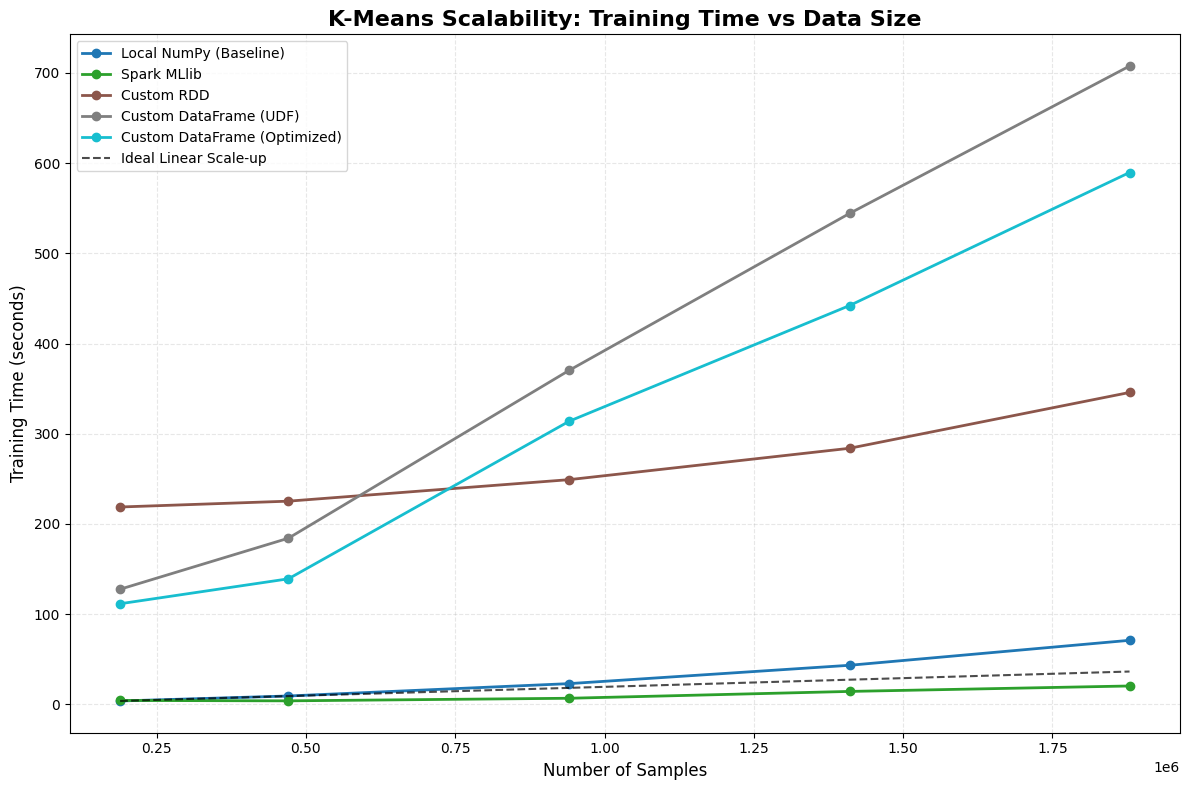

In [7]:
# Plot Scalability Results
plt.figure(figsize=(12, 8))

# Get unique models
models = results_df['Model'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

# Plot lines for each model
for i, model_name in enumerate(models):
    subset = results_df[results_df['Model'] == model_name].sort_values('Samples')
    plt.plot(subset['Samples'], subset['Time'], 'o-', linewidth=2, label=model_name, color=colors[i])

# Add Ideal Linear Scalability Line
# Based on the fastest model at the smallest sample size
min_samples = results_df['Samples'].min()
if not results_df.empty:
    baseline_time = results_df[results_df['Samples'] == min_samples]['Time'].min()
    
    # Calculate ideal line y = m*x + c passing through the first point
    # We want Time ~ Samples
    ideal_x = np.sort(results_df['Samples'].unique())
    # Scale factor: t_new = t_base * (n_new / n_base)
    ideal_y = baseline_time * (ideal_x / min_samples)
    
    plt.plot(ideal_x, ideal_y, 'k--', linewidth=1.5, alpha=0.7, label='Ideal Linear Scale-up')

plt.title('K-Means Scalability: Training Time vs Data Size', fontsize=16, fontweight='bold')
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Log-Log scale option (useful if Local model explodes)
# plt.xscale('log')
# plt.yscale('log')

plt.tight_layout()
plt.show()